In [84]:
# hide
# all_slow

In [85]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq git+https://github.com/thinkingmachines/geowrangler.git

In [86]:
# hide
# no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [87]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Geowrangler Overview - Ookla Demo

> Sample demo for using geowrangler to find the Philippine provinces/towns with the slowest/fastest internet speeds.  

## Summary

### How geowrangler can make this process easier
* Validate your geodataframes
* Help you download Ookla data (internet speed)
* Generate zonal stats for your province/town

### What you need to do

* Get AOIs - get the boundaries of your admin regions
* Download ookla data
* Validate AOIs and ookla data
* Generate zonal Stats
* Analyze and find fastest/slowest internet speeds

In [88]:
# hide
import warnings

warnings.filterwarnings(action="ignore", category=UserWarning, module="geopandas")

In [89]:
import geopandas as gpd
import matplotlib.pyplot as plt
import geowrangler.area_zonal_stats as azs

In [90]:
import pandas as pd

pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

In [91]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson files from repo
# ![ ! -e ../data/region3_population_bgy_level.geojson ] && curl -s -o ../data/region3_population_bgy_level.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region3_population_bgy_level.geojson

## Tutorial 

### Download Admin Areas

* Get [data from Humanitarian Data Exchange](https://data.humdata.org/dataset/cod-ab-phl)  

In [92]:
# REGION_FILTER = None  # All regions
REGION_FILTER = "National Capital Region"  # limit to 1 to speed up processing

In [93]:
phl_admin3_file = "phl_adminboundaries_candidate_adm3"
phl_admin3_zip = f"{phl_admin3_file}.zip"
# shapefiles
phl_admin3_link = f"https://data.humdata.org/dataset/caf116df-f984-4deb-85ca-41b349d3f313/resource/12457689-6a86-4474-8032-5ca9464d38a8/download/{phl_admin3_zip}"

In [94]:
%%time
![ ! -e ../data/{phl_admin3_zip} ] && -curl -L -o ../data/{phl_admin3_zip} {phl_admin3_link}

CPU times: user 0 ns, sys: 49.4 ms, total: 49.4 ms
Wall time: 213 ms


In [95]:
!mkdir -p ../data/{phl_admin3_file}

In [96]:
main_file = "phl_admbnda_adm3_psa_namria_20200529"
phl_admin3_shp = f"../data/{phl_admin3_file}/{main_file}.shp"

In [97]:
%%time
![ ! -e {phl_admin3_shp} ] && unzip -d ../data/{phl_admin3_file} ../data/{phl_admin3_zip}

CPU times: user 0 ns, sys: 59.8 ms, total: 59.8 ms
Wall time: 221 ms


In [98]:
%%time
admin3 = gpd.read_file(phl_admin3_shp)

CPU times: user 2.92 s, sys: 632 ms, total: 3.56 s
Wall time: 3.55 s


In [99]:
admin3.head()

,Shape_Leng,Shape_Area,ADM3_EN,ADM3_PCODE,ADM3_REF,ADM3ALT1EN,ADM3ALT2EN,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,1.601219,0.063496,Aborlan,PH175301000,None,None,None,Palawan,PH175300000,Region IV-B,PH170000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"MULTIPOLYGON (((118.58350 9.37700, 118.58398 9..."
1,1.078749,0.050232,Abra de Ilog,PH175101000,None,None,None,Occidental Mindoro,PH175100000,Region IV-B,PH170000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((120.58412 13.50198, 120.58420 13.501..."
2,0.424301,0.006453,Abucay,PH030801000,None,None,None,Bataan,PH030800000,Region III,PH030000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((120.49873 14.75614, 120.49891 14.755..."
3,0.566053,0.011343,Abulug,PH021501000,None,None,None,Cagayan,PH021500000,Region II,PH020000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((121.43455 18.46651, 121.43502 18.466..."
4,1.013649,0.026124,Abuyog,PH083701000,None,None,None,Leyte,PH083700000,Region VIII,PH080000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"MULTIPOLYGON (((125.02684 10.73500, 125.02683 ..."


In [100]:
list(admin3.columns.values)

['Shape_Leng',
 'Shape_Area',
 'ADM3_EN',
 'ADM3_PCODE',
 'ADM3_REF',
 'ADM3ALT1EN',
 'ADM3ALT2EN',
 'ADM2_EN',
 'ADM2_PCODE',
 'ADM1_EN',
 'ADM1_PCODE',
 'ADM0_EN',
 'ADM0_PCODE',
 'date',
 'validOn',
 'validTo',
 'geometry']

In [101]:
admin3.ADM1_EN.unique()

array(['Region IV-B', 'Region III', 'Region II', 'Region VIII',
       'Region I', 'Region IV-A', 'Cordillera Administrative Region',
       'Region VI', 'Autonomous Region in Muslim Mindanao', 'Region XII',
       'Region VII', 'Region XIII', 'Region IX', 'Region X', 'Region V',
       'Region XI', 'National Capital Region'], dtype=object)

In [102]:
if REGION_FILTER:
    admin3 = admin3[admin3.ADM1_EN == REGION_FILTER]

In [103]:
import matplotlib.pyplot as plt

CPU times: user 123 ms, sys: 115 ms, total: 238 ms
Wall time: 76.4 ms


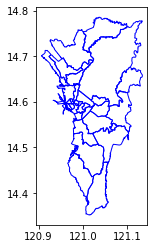

In [104]:
%%time
ax = plt.axes()
ax = admin3.plot(ax=ax, facecolor="none", edgecolor="blue")

CPU times: user 96.9 ms, sys: 61.6 ms, total: 159 ms
Wall time: 72.6 ms


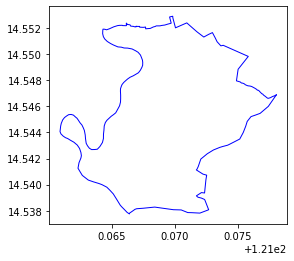

In [105]:
%%time
ax = plt.axes()
ax = admin3[admin3.ADM3_EN == "Pateros"].plot(ax=ax, facecolor="none", edgecolor="blue")

In [106]:
admin3.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [107]:
admin3.total_bounds

array([120.90639543,  14.35172957, 121.13503641,  14.78529173])

In [108]:
len(admin3)

30

### Download Ookla data

In [109]:
from geowrangler.datasets import ookla

In [110]:
%%time
ookla_dsets = ookla.list_ookla_files()
ookla_dsets

CPU times: user 13 µs, sys: 2 µs, total: 15 µs
Wall time: 18.6 µs


{OoklaQuarter(type='fixed', year='2019', quarter='1'): '2019-01-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2019', quarter='2'): '2019-04-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2019', quarter='3'): '2019-07-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2019', quarter='4'): '2019-10-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2020', quarter='1'): '2020-01-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2020', quarter='2'): '2020-04-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2020', quarter='3'): '2020-07-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2020', quarter='4'): '2020-10-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2021', quarter='1'): '2021-01-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2021', quarter='2'): '2021-04-01_performance_fixed_tiles.

In [111]:
ookla_params = dict(year="2022", quarter="2", directory="../data")

In [112]:
%%time
ookla_fixed = ookla.download_ookla_file(type_="fixed", **ookla_params)

CPU times: user 167 µs, sys: 31 µs, total: 198 µs
Wall time: 165 µs


In [113]:
%%time
ookla_mobile = ookla.download_ookla_file(type_="mobile", **ookla_params)

CPU times: user 383 µs, sys: 70 µs, total: 453 µs
Wall time: 372 µs


In [114]:
ookla_fixed

PosixPath('../data/2022-04-01_performance_fixed_tiles.parquet')

In [115]:
import pandas as pd

In [116]:
%%time
fixed = pd.read_parquet(ookla_fixed)

CPU times: user 13.1 s, sys: 37.9 s, total: 51 s
Wall time: 30.3 s


In [117]:
len(fixed)

6581735

In [118]:
fixed.head()

,quadkey,tile,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
0,2103111033100303,"POLYGON((-46.5545654296875 -22.9432183426273, ...",141501,51102,12,330,50
1,1321222320312200,"POLYGON((114.169921875 22.37039634432, 114.175...",228064,180981,5,915,191
2,1202033220030032,"POLYGON((8.536376953125 49.3143800480069, 8.54...",166267,17752,15,57,13
3,1231300223313122,"POLYGON((79.43115234375 29.6355459144667, 79.4...",42442,102038,16,14,7
4,2110000232002202,"POLYGON((-44.296875 -2.53152456690541, -44.291...",144393,52963,12,99,43


In [119]:
fixed.dtypes

quadkey       object
tile          object
avg_d_kbps     int64
avg_u_kbps     int64
avg_lat_ms     int64
tests          int64
devices        int64
dtype: object

In [120]:
%%time
fixed["geometry"] = gpd.GeoSeries.from_wkt(fixed.tile, crs="EPSG:4326")

CPU times: user 32.3 s, sys: 831 ms, total: 33.1 s
Wall time: 33.1 s


In [121]:
fixed.head()

,quadkey,tile,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
0,2103111033100303,"POLYGON((-46.5545654296875 -22.9432183426273, ...",141501,51102,12,330,50,"POLYGON ((-46.55457 -22.94322, -46.54907 -22.9..."
1,1321222320312200,"POLYGON((114.169921875 22.37039634432, 114.175...",228064,180981,5,915,191,"POLYGON ((114.16992 22.37040, 114.17542 22.370..."
2,1202033220030032,"POLYGON((8.536376953125 49.3143800480069, 8.54...",166267,17752,15,57,13,"POLYGON ((8.53638 49.31438, 8.54187 49.31438, ..."
3,1231300223313122,"POLYGON((79.43115234375 29.6355459144667, 79.4...",42442,102038,16,14,7,"POLYGON ((79.43115 29.63555, 79.43665 29.63555..."
4,2110000232002202,"POLYGON((-44.296875 -2.53152456690541, -44.291...",144393,52963,12,99,43,"POLYGON ((-44.29688 -2.53152, -44.29138 -2.531..."


In [122]:
%%time
fixed.drop(columns=["tile"], inplace=True)

CPU times: user 296 ms, sys: 118 ms, total: 414 ms
Wall time: 439 ms


In [123]:
%%time
fixed = gpd.GeoDataFrame(fixed, geometry="geometry", crs="EPSG:4326")

CPU times: user 63.8 ms, sys: 42 ms, total: 106 ms
Wall time: 113 ms


### Validate AOI and Data Geoms

In [124]:
from geowrangler.validation import GeometryValidation

#### Validate AOI

In [125]:
admin3_gvm = GeometryValidation(admin3)

In [126]:
%%time
valid_admin3 = admin3_gvm.validate_all()

CPU times: user 407 ms, sys: 17.4 ms, total: 424 ms
Wall time: 489 ms


In [127]:
(~valid_admin3.is_oriented_properly).sum(axis=None)

30

In [128]:
(~valid_admin3.is_not_null).sum(axis=None)

0

In [129]:
(~valid_admin3.is_not_self_intersecting).sum(axis=None)

0

In [130]:
(~valid_admin3.is_within_crs_bounds).sum(axis=None)

0

In [131]:
(~valid_admin3.area_is_not_zero).sum(axis=None)

0

In [132]:
valid_admin3.drop(
    columns=[
        "is_not_null",
        "is_not_self_intersecting",
        "is_oriented_properly",
        "is_within_crs_bounds",
        "area_is_not_zero",
    ],
    inplace=True,
)

#### Validate Data

In [133]:
%%time
valid_admin3.geometry.sindex

CPU times: user 1.51 ms, sys: 647 µs, total: 2.15 ms
Wall time: 4.64 ms


In [134]:
%%time
fixed.geometry.sindex

CPU times: user 13.2 s, sys: 2.15 s, total: 15.3 s
Wall time: 15.9 s


In [135]:
%%time
filtered_fixed = fixed.sjoin(
    valid_admin3[["geometry"]], how="inner", predicate="intersects"
)

CPU times: user 1.56 s, sys: 1.35 s, total: 2.91 s
Wall time: 2.96 s


In [136]:
filtered_fixed.drop(columns=["index_right"], inplace=True)

In [137]:
fixed_gvm = GeometryValidation(filtered_fixed)

In [138]:
%%time
valid_fixed = fixed_gvm.validate_all()

CPU times: user 577 ms, sys: 15.9 ms, total: 593 ms
Wall time: 620 ms


In [139]:
%%time
(~valid_fixed.is_oriented_properly).sum(axis=None)

CPU times: user 555 µs, sys: 0 ns, total: 555 µs
Wall time: 487 µs


2300

In [140]:
(~valid_fixed.is_not_null).sum(axis=None)

0

In [141]:
(~valid_fixed.is_not_self_intersecting).sum(axis=None)

0

In [142]:
(~valid_fixed.is_within_crs_bounds).sum(axis=None)

0

In [143]:
(~valid_fixed.area_is_not_zero).sum(axis=None)

0


### Generate Zonal Stats


In [144]:
filtered_fixed.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
32,1323031202232110,91002,90240,5,2473,562,"POLYGON ((121.05835 14.64737, 121.06384 14.647..."
1136,1323031202223301,86466,74067,6,1941,514,"POLYGON ((121.00891 14.62611, 121.01440 14.626..."
1258,1323031202232221,88322,71391,9,2106,551,"POLYGON ((121.03088 14.61548, 121.03638 14.615..."
1687,1323031202232300,70744,64286,6,1318,415,"POLYGON ((121.04736 14.62611, 121.05286 14.626..."
1865,1323031202221332,94282,86438,7,1466,329,"POLYGON ((121.01440 14.65268, 121.01990 14.652..."


In [145]:
list(filtered_fixed.columns.values)

['quadkey',
 'avg_d_kbps',
 'avg_u_kbps',
 'avg_lat_ms',
 'tests',
 'devices',
 'geometry']

In [146]:
len(filtered_fixed)

2300

In [147]:
%%time
valid_admin3 = valid_admin3.to_crs("EPSG:3857")

CPU times: user 28.8 ms, sys: 0 ns, total: 28.8 ms
Wall time: 41.7 ms


In [148]:
%%time
filtered_fixed = filtered_fixed.to_crs("EPSG:3857")

CPU times: user 17.4 ms, sys: 0 ns, total: 17.4 ms
Wall time: 16.4 ms


In [149]:
%%time
valid_admin3.to_file("../data/valid_admin3.geojson", driver="GeoJSON")

CPU times: user 296 ms, sys: 9.8 ms, total: 306 ms
Wall time: 376 ms


In [150]:
%%time
filtered_fixed.to_file("../data/filtered_fixed.geojson", driver="GeoJSON")

CPU times: user 618 ms, sys: 3.2 ms, total: 621 ms
Wall time: 619 ms


In [151]:
# %%time
# valid_admin3 = gpd.read_file("../data/valid_admin3.geojson")

In [152]:
# %%time
# filtered_fixed = gpd.read_file("../data/filtered_fixed.geojson")

In [153]:
funcs = ["mean", "min", "max", "std"]
columns = ["avg_d_kbps", "avg_u_kbps", "avg_lat_ms"]

In [154]:
aggregations = [dict(func=funcs, column=c) for c in columns]

In [155]:
aggregations

[{'func': ['mean', 'min', 'max', 'std'], 'column': 'avg_d_kbps'},
 {'func': ['mean', 'min', 'max', 'std'], 'column': 'avg_u_kbps'},
 {'func': ['mean', 'min', 'max', 'std'], 'column': 'avg_lat_ms'}]

In [156]:
%%time
aoi = azs.create_area_zonal_stats(
    valid_admin3, filtered_fixed, aggregations=aggregations
)

CPU times: user 5.32 s, sys: 0 ns, total: 5.32 s
Wall time: 5.39 s



### Analyze Zonal Stats


In [157]:
aoi.head()

,Shape_Leng,Shape_Area,ADM3_EN,ADM3_PCODE,ADM3_REF,ADM3ALT1EN,ADM3ALT2EN,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry,intersect_area_sum,avg_d_kbps_mean,avg_d_kbps_min,avg_d_kbps_max,avg_d_kbps_std,avg_u_kbps_mean,avg_u_kbps_min,avg_u_kbps_max,avg_u_kbps_std,avg_lat_ms_mean,avg_lat_ms_min,avg_lat_ms_max,avg_lat_ms_std
211,0.037803,0.000056,Binondo,PH133902000,None,None,None,"NCR, City of Manila, First District",PH133900000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((13467140.279 1643403.808, 13467170.0...",2.330890e+06,15125.377199,0.0,97827,4141.081774,12152.916247,0.0,80923,5625.791089,1.228832,0.0,8,0.923381
308,0.692758,0.004468,Caloocan City,PH137501000,None,None,None,"NCR, Third District",PH137500000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"MULTIPOLYGON (((13471724.654 1653701.565, 1347...",7.425998e+07,309.956521,0.0,123236,15346.775252,307.716950,0.0,117885,15118.576034,0.035243,0.0,59,6.147227
395,0.362306,0.002745,City of Las Piñas,PH137601000,City of Las Pinas,None,None,"NCR, Fourth District",PH137600000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"MULTIPOLYGON (((13467568.063 1630171.435, 1346...",4.080667e+07,649.603501,0.0,175810,22328.120899,555.324817,0.0,136167,19944.226971,0.045298,0.0,146,11.110505
398,0.260317,0.002094,City of Makati,PH137602000,None,None,None,"NCR, Fourth District",PH137600000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((13473518.917 1639376.906, 13473461.1...",3.840895e+07,765.462383,0.0,159496,16771.721664,663.200995,0.0,144939,17818.361374,0.091436,0.0,25,5.288884
399,0.262034,0.001323,City of Malabon,PH137502000,None,None,None,"NCR, Third District",PH137500000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((13461569.031 1654955.161, 13461520.7...",2.583556e+07,1006.838781,0.0,119622,13444.542392,933.345049,0.0,130002,14309.585589,0.096779,0.0,17,2.893162


In [158]:
%%time
aoi.to_file("../data/admin3_internet_aoi.geojson", driver="GeoJSON")

CPU times: user 554 ms, sys: 0 ns, total: 554 ms
Wall time: 554 ms


In [159]:
list(aoi.columns.values)

['Shape_Leng',
 'Shape_Area',
 'ADM3_EN',
 'ADM3_PCODE',
 'ADM3_REF',
 'ADM3ALT1EN',
 'ADM3ALT2EN',
 'ADM2_EN',
 'ADM2_PCODE',
 'ADM1_EN',
 'ADM1_PCODE',
 'ADM0_EN',
 'ADM0_PCODE',
 'date',
 'validOn',
 'validTo',
 'geometry',
 'intersect_area_sum',
 'avg_d_kbps_mean',
 'avg_d_kbps_min',
 'avg_d_kbps_max',
 'avg_d_kbps_std',
 'avg_u_kbps_mean',
 'avg_u_kbps_min',
 'avg_u_kbps_max',
 'avg_u_kbps_std',
 'avg_lat_ms_mean',
 'avg_lat_ms_min',
 'avg_lat_ms_max',
 'avg_lat_ms_std']

In [160]:
%%time
fastest_mean_download = aoi.sort_values("avg_d_kbps_mean", ascending=False)

CPU times: user 4.05 ms, sys: 1.57 ms, total: 5.63 ms
Wall time: 7.33 ms


In [161]:
len(fastest_mean_download)

30

In [162]:
fastest_mean_download.iloc[0]

Shape_Leng                                                     0.037803
Shape_Area                                                     0.000056
ADM3_EN                                                         Binondo
ADM3_PCODE                                                  PH133902000
ADM3_REF                                                           None
ADM3ALT1EN                                                         None
ADM3ALT2EN                                                         None
ADM2_EN                             NCR, City of Manila, First District
ADM2_PCODE                                                  PH133900000
ADM1_EN                                         National Capital Region
ADM1_PCODE                                                  PH130000000
ADM0_EN                                               Philippines (the)
ADM0_PCODE                                                           PH
date                                                         201

In [163]:
fastest_mean_download.iloc[29]

Shape_Leng                                                     0.773902
Shape_Area                                                      0.01363
ADM3_EN                                                     Quezon City
ADM3_PCODE                                                  PH137404000
ADM3_REF                                                           None
ADM3ALT1EN                                                         None
ADM3ALT2EN                                                         None
ADM2_EN                                            NCR, Second District
ADM2_PCODE                                                  PH137400000
ADM1_EN                                         National Capital Region
ADM1_PCODE                                                  PH130000000
ADM0_EN                                               Philippines (the)
ADM0_PCODE                                                           PH
date                                                         201

In [164]:
fastest_mean_download.head()

,Shape_Leng,Shape_Area,ADM3_EN,ADM3_PCODE,ADM3_REF,ADM3ALT1EN,ADM3ALT2EN,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry,intersect_area_sum,avg_d_kbps_mean,avg_d_kbps_min,avg_d_kbps_max,avg_d_kbps_std,avg_u_kbps_mean,avg_u_kbps_min,avg_u_kbps_max,avg_u_kbps_std,avg_lat_ms_mean,avg_lat_ms_min,avg_lat_ms_max,avg_lat_ms_std
211,0.037803,0.000056,Binondo,PH133902000,None,None,None,"NCR, City of Manila, First District",PH133900000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((13467140.279 1643403.808, 13467170.0...",2.330890e+06,15125.377199,0.0,97827,4141.081774,12152.916247,0.0,80923,5625.791089,1.228832,0.0,8,0.923381
1343,0.053487,0.000078,San Nicolas,PH133904000,None,None,None,"NCR, City of Manila, First District",PH133900000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((13466744.672 1642984.779, 13466729.4...",2.664462e+06,10897.783018,0.0,102244,7120.360056,9006.193022,0.0,86747,7700.042780,0.704346,0.0,8,1.506245
1192,0.037150,0.000074,Quiapo,PH133903000,None,None,None,"NCR, City of Manila, First District",PH133900000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((13468655.228 1642642.753, 13468654.8...",2.662329e+06,9799.121085,0.0,98873,10795.824603,8118.883151,0.0,80923,6614.199092,0.918342,0.0,9,0.907896
1336,0.048487,0.000076,San Miguel,PH133907000,None,None,None,"NCR, City of Manila, First District",PH133900000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((13468957.316 1643213.115, 13468945.4...",2.487809e+06,8708.791412,0.0,98873,9888.900686,6668.758487,0.0,80182,7787.458224,0.768447,0.0,11,1.742236
1112,0.068193,0.000135,Pateros,PH137606000,None,None,None,"NCR, Fourth District",PH137600000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((13477449.820 1637654.605, 13477440.2...",3.712584e+06,7581.975774,0.0,111250,14222.228691,7589.466134,0.0,111699,16454.487517,0.653218,0.0,22,6.301402


In [165]:
fastest_mean_download.tail()

,Shape_Leng,Shape_Area,ADM3_EN,ADM3_PCODE,ADM3_REF,ADM3ALT1EN,ADM3ALT2EN,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry,intersect_area_sum,avg_d_kbps_mean,avg_d_kbps_min,avg_d_kbps_max,avg_d_kbps_std,avg_u_kbps_mean,avg_u_kbps_min,avg_u_kbps_max,avg_u_kbps_std,avg_lat_ms_mean,avg_lat_ms_min,avg_lat_ms_max,avg_lat_ms_std
1521,0.358176,0.002988,Taguig City,PH137607000,None,None,None,"NCR, Fourth District",PH137600000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((13478681.270 1637104.712, 13478678.4...",4.580863e+07,531.559943,0.0,269126,22554.675088,533.756924,0.0,338848,26592.431370,0.049094,0.0,52,4.886918
411,0.431594,0.003758,City of Parañaque,PH137604000,City of Paranaque,None,None,"NCR, Fourth District",PH137600000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((13469451.308 1635447.373, 13469437.9...",6.008058e+07,470.491966,0.0,211977,26102.256841,410.888659,0.0,322898,27586.935324,0.043364,0.0,21,3.096822
436,0.413528,0.003907,City of Valenzuela,PH137504000,None,None,None,"NCR, Third District",PH137500000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((13469429.055 1661215.289, 13469428.0...",5.944822e+07,420.083766,0.0,109511,14291.380211,413.566102,0.0,113195,14141.939429,0.054408,0.0,148,15.991979
308,0.692758,0.004468,Caloocan City,PH137501000,None,None,None,"NCR, Third District",PH137500000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"MULTIPOLYGON (((13471724.654 1653701.565, 1347...",7.425998e+07,309.956521,0.0,123236,15346.775252,307.716950,0.0,117885,15118.576034,0.035243,0.0,59,6.147227
1191,0.773902,0.013630,Quezon City,PH137404000,None,None,None,"NCR, Second District",PH137400000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((13484683.377 1663482.482, 13484658.7...",1.745448e+08,145.111131,0.0,269544,20232.269854,133.033955,0.0,260425,20141.871761,0.011798,0.0,29,2.900160


In [166]:
fastest_mean_download[fastest_mean_download.avg_d_kbps_mean.notna()].tail()

,Shape_Leng,Shape_Area,ADM3_EN,ADM3_PCODE,ADM3_REF,ADM3ALT1EN,ADM3ALT2EN,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry,intersect_area_sum,avg_d_kbps_mean,avg_d_kbps_min,avg_d_kbps_max,avg_d_kbps_std,avg_u_kbps_mean,avg_u_kbps_min,avg_u_kbps_max,avg_u_kbps_std,avg_lat_ms_mean,avg_lat_ms_min,avg_lat_ms_max,avg_lat_ms_std
1521,0.358176,0.002988,Taguig City,PH137607000,None,None,None,"NCR, Fourth District",PH137600000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((13478681.270 1637104.712, 13478678.4...",4.580863e+07,531.559943,0.0,269126,22554.675088,533.756924,0.0,338848,26592.431370,0.049094,0.0,52,4.886918
411,0.431594,0.003758,City of Parañaque,PH137604000,City of Paranaque,None,None,"NCR, Fourth District",PH137600000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((13469451.308 1635447.373, 13469437.9...",6.008058e+07,470.491966,0.0,211977,26102.256841,410.888659,0.0,322898,27586.935324,0.043364,0.0,21,3.096822
436,0.413528,0.003907,City of Valenzuela,PH137504000,None,None,None,"NCR, Third District",PH137500000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((13469429.055 1661215.289, 13469428.0...",5.944822e+07,420.083766,0.0,109511,14291.380211,413.566102,0.0,113195,14141.939429,0.054408,0.0,148,15.991979
308,0.692758,0.004468,Caloocan City,PH137501000,None,None,None,"NCR, Third District",PH137500000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"MULTIPOLYGON (((13471724.654 1653701.565, 1347...",7.425998e+07,309.956521,0.0,123236,15346.775252,307.716950,0.0,117885,15118.576034,0.035243,0.0,59,6.147227
1191,0.773902,0.013630,Quezon City,PH137404000,None,None,None,"NCR, Second District",PH137400000,National Capital Region,PH130000000,Philippines (the),PH,2016-06-30,2020-05-29,None,"POLYGON ((13484683.377 1663482.482, 13484658.7...",1.745448e+08,145.111131,0.0,269544,20232.269854,133.033955,0.0,260425,20141.871761,0.011798,0.0,29,2.900160


### Additional Exercises

* Repeat the same process to find the fastest and slowest **mobile** internet speeds
* Repeat the same process for a different REGION_FILTER
* Aggregate by adm2 level instead of adm3
